In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import Kitti
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import csv
import seaborn as sns
import os
import random
%matplotlib inline

In [2]:
seed_number = 4
torch.manual_seed(seed_number)
np.random.seed(seed_number)
random.seed(seed_number)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

False


In [3]:
CONFIDENCE_THRESHOLD = 0.7
IOU_THRESHOLD = 0.5
AREA_THRESHOLD = {'car': 10000, 'pedestrian': 100, 'dc': 1000} # object that is shaller than this is believed to be too far away. thus not safety relevent
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [4]:
class BoundingBox:
    def __init__(self, x1, y1, x2, y2, cat = "dc"):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.cat = cat

def calculate_iou(box1, box2):
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1.x1, box2.x1)
    y_top = max(box1.y1, box2.y1)
    x_right = min(box1.x2, box2.x2)
    y_bottom = min(box1.y2, box2.y2)

    # Calculate area of intersection
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Calculate areas of the input boxes
    box1_area = (box1.x2 - box1.x1) * (box1.y2 - box1.y1)
    box2_area = (box2.x2 - box2.x1) * (box2.y2 - box2.y1)

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

def count_undetected_objects(ground_truths, predictions, iou_threshold, size_gt = 0):
    undetected_count = 0
    count_smaller = 0
    undetected_count_smaller = 0

    for gt_box in ground_truths:
        area = (gt_box.x2 - gt_box.x1) * (gt_box.y2 - gt_box.y1)        
        if area >= size_gt["dc"]:
            detected = False
            for pred_box in predictions:
                if calculate_iou(gt_box, pred_box) >= iou_threshold:
                    detected = True
                    break
            if not detected:
                undetected_count += 1
        else:
            count_smaller += 1
            detected = False
            for pred_box in predictions:
                if calculate_iou(gt_box, pred_box) >= iou_threshold:
                    detected = True
                    break
            if not detected:
                undetected_count_smaller += 1            


    return undetected_count, count_smaller, undetected_count_smaller

In [5]:
# Download and load the KITTI dataset
kitti_real_dataset = Kitti(root='data/data_real/',  transform=ToTensor(), download = False)
kitti_syn_dataset = Kitti(root='data/KITTI_Syn_ControlNet_Canny/',  transform=ToTensor(), download = False)

# Get the k-th image in the list () and its ground truth labels
image_index = 0
# image_index = 1 # With train errors

# Note that label_real and label_syn are the same
image_real, label_real = kitti_real_dataset[image_index]
image_syn, label_syn  = kitti_syn_dataset[image_index]

In [6]:
# Load the pre-trained model (note that this is not really ideal, as the model has more classes based on COCO)
model = torchvision.models.detection.fcos_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()


C:\Users\Zhao2_x\AppData\Local\anaconda3\envs\sa_fidelity\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Zhao2_x\AppData\Local\anaconda3\envs\sa_fidelity\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCOS_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FCOS_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FCOS(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=1e

In [7]:
# let us test for one image first 

bounding_boxes_real = list()
bounding_boxes_syn = list()

# Get an image from the KITTI dataset
image_real, _ = kitti_real_dataset[image_index]
image_real = image_real.to(device)

# Generate predictions for the image
with torch.no_grad():
    prediction_real = model([image_real])

# Display the image with the predicted bounding boxes
image_real = image_real.cpu()
prediction_real = prediction_real[0]
boxes_real = prediction_real['boxes'].cpu().numpy()
scores_real = prediction_real['scores'].cpu().numpy()

for box_real, score_real in zip(boxes_real, scores_real):
    if score_real > CONFIDENCE_THRESHOLD:
        x1, y1, x2, y2 = box_real
        bounding_boxes_real.append(BoundingBox(x1, y1, x2, y2))

# Get an image from the KITTI dataset
image_syn, _ = kitti_syn_dataset[image_index]
image_syn = image_syn.to(device)

# Generate predictions for the image
with torch.no_grad():
    prediction = model([image_syn])

# Display the image with the predicted bounding boxes
image_syn = image_syn.cpu()
prediction_syn = prediction[0]
boxes_syn = prediction_syn['boxes'].cpu().numpy()
scores_syn = prediction_syn['scores'].cpu().numpy()

for box_syn, score_syn in zip(boxes_syn, scores_syn):
    if score_syn > CONFIDENCE_THRESHOLD:
        x1, y1, x2, y2 = box_syn
        bounding_boxes_syn.append(BoundingBox(x1, y1, x2, y2))

undetected_count, count_smaller, undetected_count_smaller = count_undetected_objects(bounding_boxes_real, bounding_boxes_syn, IOU_THRESHOLD, AREA_THRESHOLD)

print("=== Summary comparing the detector in real and syn ===")
print("Detected in real, but undetected in syn (area larger than threshold):", undetected_count)
print("Detected objects in real; area smaller than threshold:", count_smaller)
print("Detected in real, but undetected in syn (area smaller than threshold):", undetected_count_smaller)


undetected_count, count_smaller, undetected_count_smaller = count_undetected_objects(bounding_boxes_syn, bounding_boxes_real, IOU_THRESHOLD, AREA_THRESHOLD)
print("=== ")
print("Detected in syn, but undetected in real (area larger than threshold):", undetected_count)
print("Detected objects in syn; area smaller than threshold:", count_smaller)
print("Detected in syn, but undetected in real (area smaller than threshold):", undetected_count_smaller)








=== Summary comparing the detector in real and syn ===
Detected in real, but undetected in syn (area larger than threshold): 1
Detected objects in real; area smaller than threshold: 0
Detected in real, but undetected in syn (area smaller than threshold): 0
=== 
Detected in syn, but undetected in real (area larger than threshold): 2
Detected objects in syn; area smaller than threshold: 1
Detected in syn, but undetected in real (area smaller than threshold): 1


In [8]:

inconsistency_count=[]
false_negative_count=[]
false_alarm_count=[]

for i in range(90):
    
    image_index = i
    
    bounding_boxes_real = list()
    bounding_boxes_syn = list()

    # Get an image from the KITTI dataset
    image_real, _ = kitti_real_dataset[image_index]
    image_real = image_real.to(device)

    # Generate predictions for the image
    with torch.no_grad():
        prediction_real = model([image_real])

    # Display the image with the predicted bounding boxes
    image_real = image_real.cpu()
    prediction_real = prediction_real[0]
    boxes_real = prediction_real['boxes'].cpu().numpy()
    scores_real = prediction_real['scores'].cpu().numpy()

    for box_real, score_real in zip(boxes_real, scores_real):
        if score_real > CONFIDENCE_THRESHOLD:
            x1, y1, x2, y2 = box_real
            bounding_boxes_real.append(BoundingBox(x1, y1, x2, y2))

    # Get an image from the KITTI dataset
    image_syn, _ = kitti_syn_dataset[image_index]
    image_syn = image_syn.to(device)

    # Generate predictions for the image
    with torch.no_grad():
        prediction = model([image_syn])

    # Display the image with the predicted bounding boxes
    image_syn = image_syn.cpu()
    prediction_syn = prediction[0]
    boxes_syn = prediction_syn['boxes'].cpu().numpy()
    scores_syn = prediction_syn['scores'].cpu().numpy()

    for box_syn, score_syn in zip(boxes_syn, scores_syn):
        if score_syn > CONFIDENCE_THRESHOLD:
            x1, y1, x2, y2 = box_syn
            bounding_boxes_syn.append(BoundingBox(x1, y1, x2, y2))

    inconsistency_count_tmp=0
    undetected_count, count_smaller, undetected_count_smaller = count_undetected_objects(bounding_boxes_real, bounding_boxes_syn, IOU_THRESHOLD, AREA_THRESHOLD)
    inconsistency_count_tmp = inconsistency_count_tmp + undetected_count
    false_alarm_count.append(undetected_count)
    
    undetected_count, count_smaller, undetected_count_smaller = count_undetected_objects(bounding_boxes_syn, bounding_boxes_real, IOU_THRESHOLD, AREA_THRESHOLD)
    inconsistency_count_tmp = inconsistency_count_tmp + undetected_count
    false_negative_count.append(undetected_count)
    
    inconsistency_count.append(inconsistency_count_tmp)
    

print(inconsistency_count,false_alarm_count,false_negative_count)



[3, 5, 2, 0, 4, 8, 1, 6, 3, 2, 2, 1, 1, 1, 1, 1, 3, 0, 0, 1, 0, 2, 3, 6, 2, 2, 3, 4, 5, 2, 2, 6, 0, 3, 2, 3, 1, 3, 3, 1, 3, 2, 3, 5, 1, 3, 3, 0, 4, 3, 1, 4, 6, 4, 0, 0, 2, 1, 2, 4, 0, 1, 1, 4, 2, 0, 3, 5, 5, 0, 1, 1, 5, 3, 4, 4, 0, 7, 2, 4, 4, 2, 3, 2, 5, 2, 3, 2, 2, 1] [1, 2, 2, 0, 3, 3, 1, 5, 3, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 4, 1, 2, 2, 1, 3, 2, 2, 6, 0, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 3, 1, 2, 2, 0, 2, 0, 1, 4, 4, 3, 0, 0, 2, 0, 2, 3, 0, 1, 1, 1, 2, 0, 1, 0, 1, 0, 0, 1, 3, 2, 4, 0, 0, 7, 2, 3, 3, 0, 3, 2, 5, 2, 2, 2, 2, 1] [2, 3, 0, 0, 1, 5, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 1, 2, 2, 1, 0, 1, 3, 2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 2, 0, 2, 2, 2, 2, 0, 1, 1, 0, 2, 3, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0, 2, 5, 4, 0, 1, 0, 2, 1, 0, 4, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0]


In [9]:


# Create folder, if it does not exist
folder_name = 'rq1_raw_experimental_data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Specify the filename
filename = "raw_data_fcos_cn_canny.csv"

# Define the CSV file path
file_path = os.path.join(folder_name, filename)

with open(file_path, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header (optional)
    writer.writerow(['Inconsistancy', 'FalseAlarm', 'FalseNegtive'])

    # Iterate over the lists and write rows to the CSV file
    for i in range(len(inconsistency_count)):
        writer.writerow([inconsistency_count[i], false_alarm_count[i], false_negative_count[i]])


In [10]:
# after storing the raw data, we also store the data as new varibles
inconsistency_count_fcos_cncanny,false_alarm_count_fcos_cncanny,false_negative_count_fcos_cncanny=inconsistency_count,false_alarm_count,false_negative_count


In [11]:
# repeat the process for the other two datasets

# Download and load the KITTI dataset
kitti_real_dataset = Kitti(root='data/data_real/',  transform=ToTensor(), download = False)
kitti_syn_dataset = Kitti(root='data/KITTI_Syn_ControlNet_Depth/',  transform=ToTensor(), download = False)


inconsistency_count=[]
false_negative_count=[]
false_alarm_count=[]

for i in range(90):
    
    image_index = i
    
    bounding_boxes_real = list()
    bounding_boxes_syn = list()

    # Get an image from the KITTI dataset
    image_real, _ = kitti_real_dataset[image_index]
    image_real = image_real.to(device)

    # Generate predictions for the image
    with torch.no_grad():
        prediction_real = model([image_real])

    # Display the image with the predicted bounding boxes
    image_real = image_real.cpu()
    prediction_real = prediction_real[0]
    boxes_real = prediction_real['boxes'].cpu().numpy()
    scores_real = prediction_real['scores'].cpu().numpy()

    for box_real, score_real in zip(boxes_real, scores_real):
        if score_real > CONFIDENCE_THRESHOLD:
            x1, y1, x2, y2 = box_real
            bounding_boxes_real.append(BoundingBox(x1, y1, x2, y2))

    # Get an image from the KITTI dataset
    image_syn, _ = kitti_syn_dataset[image_index]
    image_syn = image_syn.to(device)

    # Generate predictions for the image
    with torch.no_grad():
        prediction = model([image_syn])

    # Display the image with the predicted bounding boxes
    image_syn = image_syn.cpu()
    prediction_syn = prediction[0]
    boxes_syn = prediction_syn['boxes'].cpu().numpy()
    scores_syn = prediction_syn['scores'].cpu().numpy()

    for box_syn, score_syn in zip(boxes_syn, scores_syn):
        if score_syn > CONFIDENCE_THRESHOLD:
            x1, y1, x2, y2 = box_syn
            bounding_boxes_syn.append(BoundingBox(x1, y1, x2, y2))

    inconsistency_count_tmp=0
    undetected_count, count_smaller, undetected_count_smaller = count_undetected_objects(bounding_boxes_real, bounding_boxes_syn, IOU_THRESHOLD, AREA_THRESHOLD)
    inconsistency_count_tmp = inconsistency_count_tmp + undetected_count
    false_alarm_count.append(undetected_count)
    
    undetected_count, count_smaller, undetected_count_smaller = count_undetected_objects(bounding_boxes_syn, bounding_boxes_real, IOU_THRESHOLD, AREA_THRESHOLD)
    inconsistency_count_tmp = inconsistency_count_tmp + undetected_count
    false_negative_count.append(undetected_count)
    
    inconsistency_count.append(inconsistency_count_tmp)
    

print(inconsistency_count,false_alarm_count,false_negative_count)

[1, 3, 4, 2, 4, 4, 3, 6, 2, 2, 3, 0, 0, 1, 0, 1, 3, 1, 1, 4, 3, 3, 3, 5, 4, 5, 3, 3, 4, 3, 3, 7, 0, 1, 1, 4, 5, 3, 6, 1, 2, 4, 1, 3, 0, 1, 2, 2, 2, 1, 0, 4, 1, 5, 1, 0, 3, 0, 3, 6, 2, 3, 0, 5, 2, 0, 3, 2, 1, 1, 1, 1, 4, 4, 4, 3, 2, 11, 4, 5, 2, 0, 2, 3, 4, 2, 7, 2, 1, 2] [1, 2, 3, 2, 4, 3, 3, 5, 2, 2, 3, 0, 0, 1, 0, 0, 2, 1, 1, 4, 3, 3, 2, 5, 1, 3, 3, 3, 4, 3, 3, 7, 0, 1, 1, 3, 5, 3, 4, 1, 2, 0, 1, 3, 0, 1, 1, 2, 2, 1, 0, 3, 1, 3, 1, 0, 2, 0, 2, 4, 2, 2, 0, 3, 2, 0, 1, 2, 1, 1, 0, 1, 4, 4, 4, 0, 1, 8, 1, 3, 2, 0, 2, 1, 4, 2, 4, 1, 1, 2] [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 3, 1, 3, 3, 2, 0, 0, 0, 2, 0, 0, 3, 1, 0, 0]


In [12]:
# Create folder, if it does not exist
folder_name = 'rq1_raw_experimental_data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Specify the filename
filename = "raw_data_fcos_cn_depth.csv"

# Define the CSV file path
file_path = os.path.join(folder_name, filename)

with open(file_path, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header (optional)
    writer.writerow(['Inconsistancy', 'FalseAlarm', 'FalseNegtive'])

    # Iterate over the lists and write rows to the CSV file
    for i in range(len(inconsistency_count)):
        writer.writerow([inconsistency_count[i], false_alarm_count[i], false_negative_count[i]])

In [13]:
# after storing the raw data, we also store the data as new varibles
inconsistency_count_fcos_cndepth,false_alarm_count_fcos_cndepth,false_negative_count_fcos_cndepth=inconsistency_count,false_alarm_count,false_negative_count


In [14]:
# repeat the process for other datasets

# Download and load the KITTI dataset
kitti_real_dataset = Kitti(root='data/data_real/',  transform=ToTensor(), download = False)
kitti_syn_dataset = Kitti(root='data/data_syn_Carla/',  transform=ToTensor(), download = False)


inconsistency_count=[]
false_negative_count=[]
false_alarm_count=[]

for i in range(90):
    
    image_index = i
    
    bounding_boxes_real = list()
    bounding_boxes_syn = list()

    # Get an image from the KITTI dataset
    image_real, _ = kitti_real_dataset[image_index]
    image_real = image_real.to(device)

    # Generate predictions for the image
    with torch.no_grad():
        prediction_real = model([image_real])

    # Display the image with the predicted bounding boxes
    image_real = image_real.cpu()
    prediction_real = prediction_real[0]
    boxes_real = prediction_real['boxes'].cpu().numpy()
    scores_real = prediction_real['scores'].cpu().numpy()

    for box_real, score_real in zip(boxes_real, scores_real):
        if score_real > CONFIDENCE_THRESHOLD:
            x1, y1, x2, y2 = box_real
            bounding_boxes_real.append(BoundingBox(x1, y1, x2, y2))

    # Get an image from the KITTI dataset
    image_syn, _ = kitti_syn_dataset[image_index]
    image_syn = image_syn.to(device)

    # Generate predictions for the image
    with torch.no_grad():
        prediction = model([image_syn])

    # Display the image with the predicted bounding boxes
    image_syn = image_syn.cpu()
    prediction_syn = prediction[0]
    boxes_syn = prediction_syn['boxes'].cpu().numpy()
    scores_syn = prediction_syn['scores'].cpu().numpy()

    for box_syn, score_syn in zip(boxes_syn, scores_syn):
        if score_syn > CONFIDENCE_THRESHOLD:
            x1, y1, x2, y2 = box_syn
            bounding_boxes_syn.append(BoundingBox(x1, y1, x2, y2))

    inconsistency_count_tmp=0
    undetected_count, count_smaller, undetected_count_smaller = count_undetected_objects(bounding_boxes_real, bounding_boxes_syn, IOU_THRESHOLD, AREA_THRESHOLD)
    inconsistency_count_tmp = inconsistency_count_tmp + undetected_count
    false_alarm_count.append(undetected_count)
    
    undetected_count, count_smaller, undetected_count_smaller = count_undetected_objects(bounding_boxes_syn, bounding_boxes_real, IOU_THRESHOLD, AREA_THRESHOLD)
    inconsistency_count_tmp = inconsistency_count_tmp + undetected_count
    false_negative_count.append(undetected_count)
    
    inconsistency_count.append(inconsistency_count_tmp)
    

print(inconsistency_count,false_alarm_count,false_negative_count)

[0, 2, 2, 1, 3, 2, 0, 2, 3, 1, 4, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 3, 2, 0, 1, 0, 3, 2, 1, 4, 0, 0, 0, 3, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 3, 2, 0, 0, 4, 3, 3, 0, 0, 1, 0, 1, 3, 0, 0, 1, 2, 2, 1, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 4, 2, 2, 2, 0, 0, 0, 1, 1, 2, 0, 1, 0] [0, 1, 2, 1, 3, 2, 0, 2, 3, 1, 3, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 3, 1, 0, 1, 0, 3, 2, 1, 4, 0, 0, 0, 2, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 0, 3, 2, 3, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 3, 3, 0, 0, 1, 4, 1, 2, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0] [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [15]:
# Create folder, if it does not exist
folder_name = 'rq1_raw_experimental_data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Specify the filename
filename = "raw_data_fcos_syn_carla.csv"

# Define the CSV file path
file_path = os.path.join(folder_name, filename)

with open(file_path, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header (optional)
    writer.writerow(['Inconsistancy', 'FalseAlarm', 'FalseNegtive'])

    # Iterate over the lists and write rows to the CSV file
    for i in range(len(inconsistency_count)):
        writer.writerow([inconsistency_count[i], false_alarm_count[i], false_negative_count[i]])

In [16]:
# after storing the raw data, we also store the data as new varibles
inconsistency_count_fcos_carla,false_alarm_count_fcos_carla,false_negative_count_fcos_carla=inconsistency_count,false_alarm_count,false_negative_count


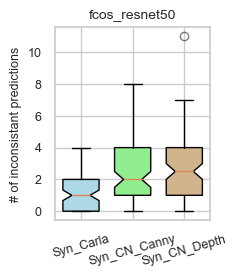

In [51]:

# Improve the aesthetics using Seaborn
sns.set(style="whitegrid")

# Sample data
data = [inconsistency_count_fcos_carla,inconsistency_count_fcos_cncanny,inconsistency_count_fcos_cndepth
]

# Create a box plot with custom colors
plt.figure(figsize=(2, 2.5))  # Set the figure size
box = plt.boxplot(data, patch_artist=True, notch=True, widths=0.7)  # Adjust widths

# Coloring each box
colors = ['lightblue', 'lightgreen', 'tan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Customizing the fliers (outliers)
for flier in box['fliers']:
    flier.set(marker='o', color='red', alpha=0.5)
# Adjusting the y-axis tick label font size
plt.gca().tick_params(axis='y', labelsize=9)  # Set the font size
# Add titles and labels
plt.title('fcos_resnet50', fontsize=10)
plt.ylabel('# of inconsistant predictions', fontsize=9)
plt.xticks([1, 2, 3], ['Syn_Carla', 'Syn_CN_Canny', 'Syn_CN_Depth'], fontsize=9,rotation=15)

# Show the plot
plt.show()


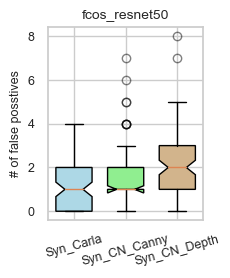

In [52]:
# Improve the aesthetics using Seaborn
sns.set(style="whitegrid")

# Sample data
data = [false_alarm_count_fcos_carla,false_alarm_count_fcos_cncanny,false_alarm_count_fcos_cndepth
]

# Create a box plot with custom colors
plt.figure(figsize=(2, 2.5))  # Set the figure size
box = plt.boxplot(data, patch_artist=True, notch=True, widths=0.7)  # Adjust widths

# Coloring each box
colors = ['lightblue', 'lightgreen', 'tan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Customizing the fliers (outliers)
for flier in box['fliers']:
    flier.set(marker='o', color='red', alpha=0.5)

# Adjusting the y-axis tick label font size
plt.gca().tick_params(axis='y', labelsize=9)  # Set the font size
# Add titles and labels
plt.title('fcos_resnet50', fontsize=10)
plt.ylabel('# of false posstives', fontsize=9)
plt.xticks([1, 2, 3], ['Syn_Carla', 'Syn_CN_Canny', 'Syn_CN_Depth'], fontsize=9,rotation=15)

# Show the plot
plt.show()

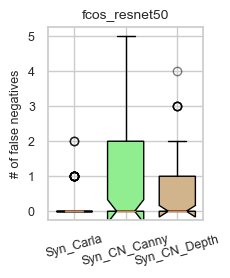

In [54]:
# Improve the aesthetics using Seaborn
sns.set(style="whitegrid")

# Sample data
data = [false_negative_count_fcos_carla,false_negative_count_fcos_cncanny,false_negative_count_fcos_cndepth
]

# Create a box plot with custom colors
plt.figure(figsize=(2, 2.5))  # Set the figure size
box = plt.boxplot(data, patch_artist=True, notch=True, widths=0.7)  # Adjust widths

# Coloring each box
colors = ['lightblue', 'lightgreen', 'tan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Customizing the fliers (outliers)
for flier in box['fliers']:
    flier.set(marker='o', color='red', alpha=0.5)

# Adjusting the y-axis tick label font size
plt.gca().tick_params(axis='y', labelsize=9)  # Set the font size
# Add titles and labels
plt.title('fcos_resnet50', fontsize=10)
plt.ylabel('# of false negatives', fontsize=9)
plt.xticks([1, 2, 3], ['Syn_Carla', 'Syn_CN_Canny', 'Syn_CN_Depth'], fontsize=9,rotation=15)

# Show the plot
plt.show()